The following cell defines the right hand side of all of the governing equations (time derivates of the parameters) of the SEIRD system.

In [1]:
import numpy as np

def seird_rhs_multi(u, t, params):
    """
    du/dt for multi-group SEIRD with vaccination rollout.

    State layout (for G groups):
        u = [S0,E0,I0,R0,D0,  S1,E1,I1,R1,D1, ...]
    
    params is a dict with:
        beta_mat : (G x G) array, beta_mat[g,h] = transmission from I_h -> S_g
        sigma    : length-G array, incubation rate for group g
        gamma    : length-G array, recovery rate for group g
        mu       : length-G array, mortality rate for group g
        vaccine_rate : function handle vaccine_rate(t, g) giving nu_g(t)
                       (fraction per time vaccinated out of S_g)
    """

    beta_mat   = params["beta_mat"]
    sigma      = params["sigma"]
    gamma      = params["gamma"]
    mu         = params["mu"]
    vaccine_fn = params["vaccine_rate"]

    G = len(sigma)
    du = np.zeros_like(u)

    def idx(g):
        base = 5*g
        return base, base+1, base+2, base+3, base+4  # S,E,I,R,D indices

    # grab all I_h for infection coupling
    I_all = np.array([u[idx(h)[2]] for h in range(G)])

    for g in range(G):
        iS, iE, iI, iR, iD = idx(g)

        Sg = u[iS]
        Eg = u[iE]
        Ig = u[iI]
        Rg = u[iR]
        Dg = u[iD]

        # vaccination rate for this group at this time
        nu_g = vaccine_fn(t, g)  # this can be 0 if group g isn't being vaccinated now

        # force of infection on group g from all h
        infection_rate_g = np.sum(beta_mat[g, :] * Sg * I_all)

        dSdt = -infection_rate_g - nu_g * Sg
        dEdt =  infection_rate_g - sigma[g] * Eg
        dIdt =  sigma[g] * Eg - (gamma[g] + mu[g]) * Ig
        dRdt =  gamma[g] * Ig + nu_g * Sg
        dDdt =  mu[g] * Ig

        du[iS] = dSdt
        du[iE] = dEdt
        du[iI] = dIdt
        du[iR] = dRdt
        du[iD] = dDdt

    return du

This cell is used to define the specifics of the desired vaccination strategy for the model. It allows us to change which group recieves the vaccine, at what rate that happens, and how long into the simulation this will begin.

In [149]:
def vaccine_rate(t, g):
    rollout = 50.0 ###days into the simulation that the vaccine will become available
    if t > rollout and g == 0:
        return 0.0  # *100 = % per day
    if t > rollout and g == 1:
        return 0.0  # *100 = % per day
    if t > rollout and g == 2:
        return 0.00  # *100 = % per day
    return 0.0

The next cell is the function to do a single time step of the RK4 method, advancing by just one interval of dt. The interval of dt is changed to a reasonable value based on how much real time we are modeling for each scenario. This function will work for any combination of initial conditions or disease parameters.

In [150]:
def rk4_step(u, t, dt, params, rhs_func):
    k1 = rhs_func(u,               t,               params)
    k2 = rhs_func(u + 0.5*dt*k1,   t + 0.5*dt,      params)
    k3 = rhs_func(u + 0.5*dt*k2,   t + 0.5*dt,      params)
    k4 = rhs_func(u + dt*k3,       t + dt,          params)

    return u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

[0.399, 0.001, 0.0, 0.0, 0.0, 0.199, 0.001, 0.0, 0.0, 0.0, 0.399, 0.001, 0.0, 0.0, 0.0]


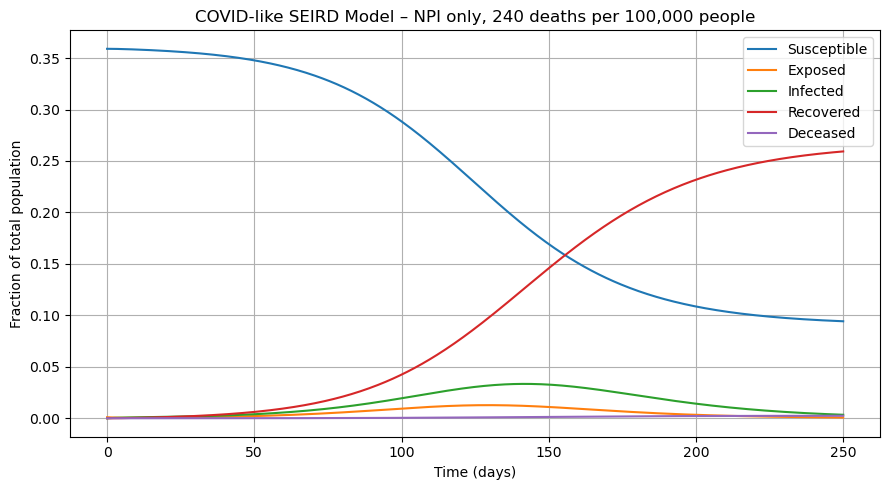

In [ ]:
import matplotlib.pyplot as plt
G = 3
incubation_period = 5 #days
infectious_period = 14 #days
sigma = np.array([1/incubation_period, 1/incubation_period, 1/incubation_period])      # incubation
gamma = np.array([1/infectious_period, 1/infectious_period, 1/infectious_period])   # recovery, the denominator is the total amount of days that the person is infected for

mu    = np.array([0.0005,0.002,0.0005])   # mortality per group, this is the percentage chance every day that the infected will die, so we take the known fatality rate of the disease and divide it by the amount of days they are infected

R0_group = np.array([3*0.8, 1.5*0.8, 2*0.8])###infections caused by each new infected person, differs between groups

beta_per_group = R0_group * (gamma + mu)

beta_mat = np.tile(beta_per_group, (G, 1))

params = {
    "beta_mat": beta_mat,
    "sigma":    sigma,
    "gamma":    gamma,
    "mu":       mu,
    "vaccine_rate": vaccine_rate  # <- our rollout policy function
}

# Define group populations (fractions of the total)
pop_fracs = np.array([0.4, 0.2, 0.4])  # group 0, group 1, group 2

# Define how much of each group starts in each state
E_seed = 1e-3  # * 100 = % of initially exposed people
u0 = []

for g in range(3):
    Sg = pop_fracs[g] - E_seed  # everyone starts susceptible except tiny exposed
    Eg = E_seed
    Ig = 0.0
    Rg = 0.0
    Dg = 0.0
    u0.extend([Sg, Eg, Ig, Rg, Dg])

u0 = np.array(u0, dtype=float)

# normalize across all groups to make sure the sum = 1
u0 /= np.sum(u0)
print(u0.tolist())
t0 = 0.0
T  = 250
dt = 0.5
N  = int((T - t0)/dt)

t_vals = np.linspace(t0, T, N+1)
u_vals = np.zeros((N+1, len(u0)))
u_vals[0] = u0

u = u0.copy()
t = t0

for k in range(N):
    u = rk4_step(u, t, dt, params, seird_rhs_multi)
    t += dt
    u_vals[k+1] = u

u_reshaped = u_vals.reshape(len(t_vals), G, 5)  # axis2 = [S,E,I,R,D]

# total population in each compartment
S_total = np.sum(u_reshaped[:, :, 0] * pop_fracs[np.newaxis, :], axis=1)
E_total = np.sum(u_reshaped[:, :, 1] * pop_fracs[np.newaxis, :], axis=1)
I_total = np.sum(u_reshaped[:, :, 2] * pop_fracs[np.newaxis, :], axis=1)
R_total = np.sum(u_reshaped[:, :, 3] * pop_fracs[np.newaxis, :], axis=1)
D_total = np.sum(u_reshaped[:, :, 4] * pop_fracs[np.newaxis, :], axis=1)



# --- plot the summed (whole-population) curves ---
plt.figure(figsize=(9,5))
plt.plot(t_vals, S_total, label='Susceptible')
plt.plot(t_vals, E_total, label='Exposed')
plt.plot(t_vals, I_total, label='Infected')
plt.plot(t_vals, R_total, label='Recovered')
plt.plot(t_vals, D_total, label='Deceased')

plt.xlabel('Time (days)')
plt.ylabel('Fraction of total population')
plt.title('COVID-like SEIRD Model – NPI only, 240 deaths per 100,000 people')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('COVID_SEIRD_NPI only.pdf')
plt.show()


This cell extracts and prints the total fraction of the dead population for the scenario being modeled.

In [ ]:
u_final = u_reshaped[-1]   # shape (G, 5)

# Fraction of dead people in each group
D_per_group = u_final[:, 4]   # column 4 = D
print((D_per_group[0]*pop_fracs[0] + D_per_group[1]*pop_fracs[1]+D_per_group[2]*pop_fracs[2])*100000, 'deaths per 100,000 population')
# Total fraction of dead population (sum across groups)
D_overall = np.sum(D_per_group)

# Print results
#print("Final fraction of deceased population (total): {:.4f}".format(D_overall))
#for g, Dg in enumerate(D_per_group):
#    print(f"  Group {g+1} deceased fraction: {Dg:.4f}")

240.9624079523238 deaths per 100,000 population
